<a href="https://colab.research.google.com/github/EsmeBarker/Collab/blob/main/EsmeBarkU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

For this project, I'm using a dataset containing information about the most popular songs on spotify. It has a lot of information, but I'm really only interested in the "acousticness percentage" and amount of playlists it's in

In [2]:
url = 'https://raw.githubusercontent.com/EsmeBarker/Collab/refs/heads/main/Popular_Spotify_Songs.csv'
songs = pd.read_csv(url, encoding='cp1252')
songs

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,...,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,...,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,...,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,...,97,C#,Major,82,67,77,8,0,12,5


I want to see if there's a relationship between how acoustic a song is and how many people add it to their playlist. I'll start by just putting all the data on a scatterplot so I can see what that relationship roughly looks like.

<Axes: xlabel='acousticness_%', ylabel='in_spotify_playlists'>

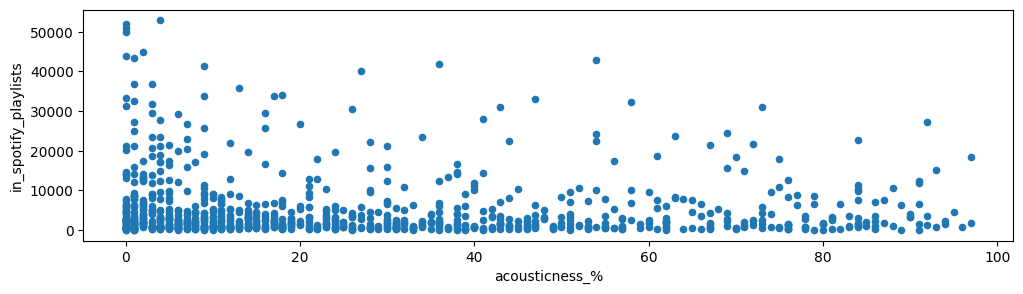

In [3]:
songs.plot(x = "acousticness_%", y = "in_spotify_playlists", figsize = (12,3), kind="scatter")

Next I made my first model, using a geometric function for the likelihood, since that looked like it sort of matched the scatterplot

In [ ]:
with pm.Model() as model_ap:

    α = pm.Normal("α", mu=5000, sigma=100)

    β = pm.Normal("β", mu=0, sigma=50)

    μ = pm.Deterministic("μ", α + β * songs['acousticness_%'])

    p = pm.Deterministic("p", 1 / (μ + 1))

    y_pred = pm.Geometric("y_pred", p=p, observed=songs.in_spotify_playlists)

    idata_ap = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_ap, model=model_ap,  extend_inferencedata=True)

The mean regression line didn't have a very dramatic slope, suggesting that there's not much of a correlation.

Text(0, 0.5, 'spotify playlists')

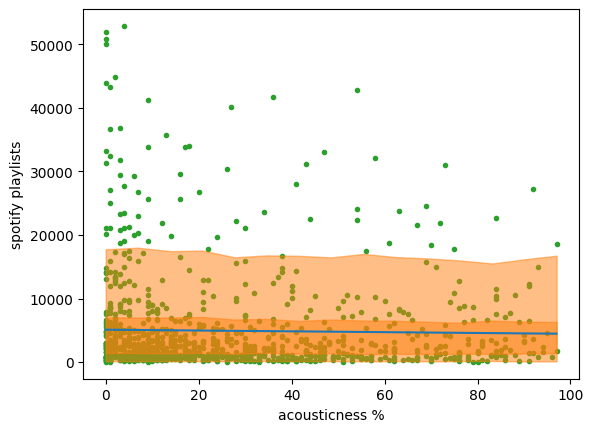

In [7]:
mean_alpha = idata_ap.posterior["α"].mean().item()
mean_beta = idata_ap.posterior["β"].mean().item()

predictions = mean_alpha + mean_beta * songs['acousticness_%'].values

ac = np.random.normal(songs['acousticness_%'].values, 0.01)
idx = np.argsort(ac)
x = np.linspace(ac.min(), ac.max(), 15)


y_pred_q = idata_ap.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

y_hat_bounds = iter(
    [
        PchipInterpolator(ac[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)


_, ax = plt.subplots()
ax.plot(songs['acousticness_%'], songs.in_spotify_playlists, "C2.", zorder=-3)

ax.plot(songs['acousticness_%'][idx], predictions[idx], c="C0")


for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("acousticness %")
ax.set_ylabel("spotify playlists")

The posterior predictive check showed that the model fit the observed data well, so the weak negative slope is probably accurate

<Axes: xlabel='y_pred'>

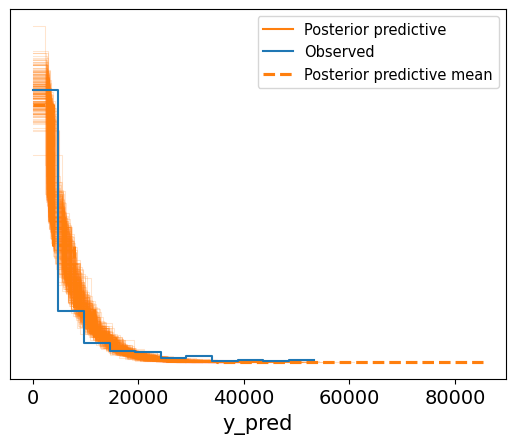

In [8]:
az.plot_ppc(idata_ap, num_pp_samples=200, colors=["C1", "C0", "C1"])

For my second model, I decided on an exponential function to compare the geometric one to.

In [ ]:
with pm.Model() as model_2:
    α = pm.Normal("α", mu=3000, sigma=500)
    β = pm.Normal("β", mu=0, sigma=50)

    µ = pm.Deterministic("µ", α + β * songs['acousticness_%'])
    y_pred = pm.Exponential("y_pred",
                     scale = µ,
                     observed=songs.in_spotify_playlists)
    idata_ap_h = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_ap_h, model=model_2, extend_inferencedata=True)

This is not really that different looking from the geometric likelihood, but that makes sense considering that the relationship was not that strong and the geometric function already fit pretty well.

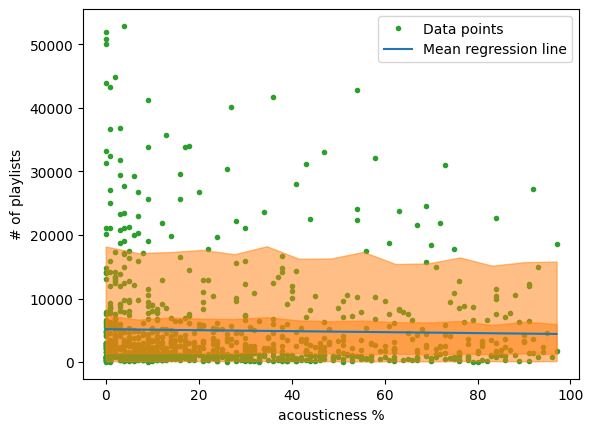

In [11]:
mean_alpha = idata_ap_h.posterior["α"].mean().item()
mean_beta = idata_ap_h.posterior["β"].mean().item()

predictions = mean_alpha + mean_beta * songs['acousticness_%'].values


acousticness = np.random.normal(songs['acousticness_%'].values, 0.01)
idx = np.argsort(acousticness)
x = np.linspace(acousticness.min(), acousticness.max(), 15)

y_pred_q = idata_ap_h.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(acousticness[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(songs['acousticness_%'], songs.in_spotify_playlists, "C2.", zorder=-3, label='Data points')

sorted_acousticness = np.sort(songs['acousticness_%'].values)
sorted_predictions = predictions[np.argsort(songs['acousticness_%'].values)]
ax.plot(sorted_acousticness, sorted_predictions, c="C0", label="Mean regression line")


for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("acousticness %")
ax.set_ylabel("# of playlists")
ax.legend()

The posterior check shows that this model also worked well.

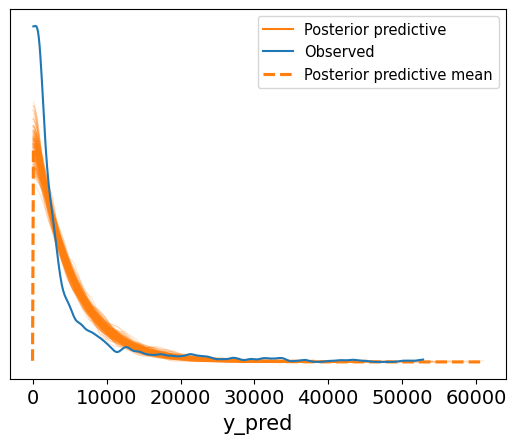

In [12]:
az.plot_ppc(idata_ap_h, num_pp_samples=200, colors=["C1", "C0", "C1"])
plt.show()

This model seems generally a bit more accurate, except for that the peak is too low.

In conclusion, the relationship between the acousticness % of a spotify song and how likely people are to add it to their playlist is pretty weak, but less acoustic songs may have a higher chance.